In [ ]:
from typing import Dict, List

import torch
from datasets import load_dataset
from datasets.iterable_dataset import IterableDataset
from roberta.models import CustomRobertaConfig, CustomRobertaForMaskedLM
from transformers import RobertaTokenizer
from transformers.utils import logging

from sobalib.layers import LowRankAttention, MonarchAttention

logging.set_verbosity_error()

ds = load_dataset("wikipedia", "20220301.en", split="train", streaming=True)
assert isinstance(ds, IterableDataset)
ds_examples = ds.take(1)
texts = [item["text"] for item in ds_examples]

/Users/cjyaras/Desktop/soba/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
inputs = tokenizer(texts, return_tensors="pt", max_length=256, truncation=True)

In [6]:
with open("text.txt", "w") as f:
    f.write(tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True))

In [ ]:
base_config = CustomRobertaConfig.from_pretrained("mtreviso/sparsemax-roberta")
config = CustomRobertaConfig.from_dict(base_config.to_dict())
model = CustomRobertaForMaskedLM.from_pretrained(
    "mtreviso/sparsemax-roberta", config=config
)

In [ ]:
def register_qk_hook(
    model: CustomRobertaForMaskedLM,
    all_layer_intermediates: List[Dict[str, torch.Tensor]],
):
    layers = model.roberta.encoder.layer

    for layer_idx in range(len(layers)):
        attn_layer = layers[layer_idx].attention.self

        def query_hook(_layer_idx):
            def hook(module, input, output):
                all_layer_intermediates[_layer_idx].update(
                    {"query": attn_layer.transpose_for_scores(output)}
                )

            return hook

        def key_hook(_layer_idx):
            def hook(module, input, output):
                all_layer_intermediates[_layer_idx].update(
                    {"key": attn_layer.transpose_for_scores(output)}
                )

            return hook

        attn_layer.query.register_forward_hook(query_hook(layer_idx))
        attn_layer.key.register_forward_hook(key_hook(layer_idx))


all_layer_intermediates = [{} for _ in range(config.num_hidden_layers)]
register_qk_hook(model, all_layer_intermediates)

with torch.no_grad():
    model(**inputs).logits

all_query = torch.stack(
    [layer_intermediates["query"] for layer_intermediates in all_layer_intermediates],
    dim=0,
).transpose(1, 0)

all_key = torch.stack(
    [layer_intermediates["key"] for layer_intermediates in all_layer_intermediates],
    dim=0,
).transpose(1, 0)

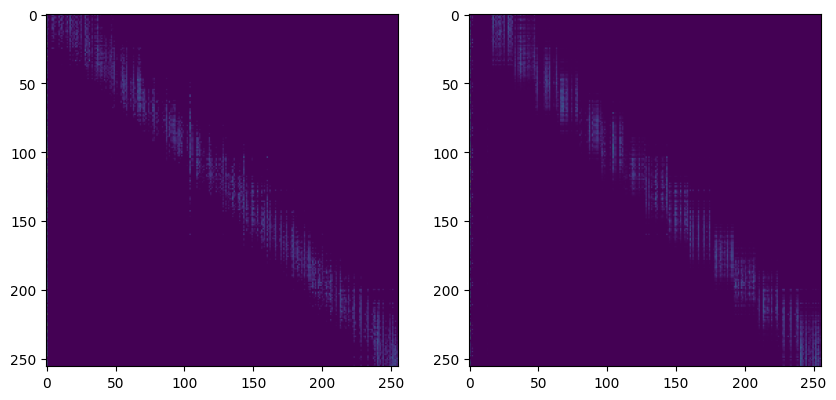

In [38]:
from math import sqrt

import matplotlib.pyplot as plt
from entmax import sparsemax

with torch.no_grad():
    # layer, head = 0, 0
    # layer, head = 0, 0
    layer, head = 5, 0

    query = all_query[0, layer, head] / sqrt(all_query.shape[-1])
    key = all_key[0, layer, head]
    attn_scores = query @ key.T

    efficient_attn = MonarchAttention(16, 20, 1e5, "post", renormalize=False)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(sparsemax(attn_scores))  # type: ignore
    ax[1].imshow(efficient_attn.get_matrix(query, key))
    plt.show()
